# Workload evaluation

In [1]:
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_style("whitegrid")

In [2]:
# get access to our utility scripts
import sys
utils_path = "../utils/"
if not utils_path in sys.path:
    sys.path.insert(0, utils_path)
from helper import *

## Data loading

In [3]:
df1 = pd.read_csv("workloads/job-full-run1-cout.csv")
df1["run"] = 1
df1.plan = df1.plan.apply(json.loads)

df2 = pd.read_csv("workloads/job-full-run2-cout.csv")
df2["run"] = 2
df2.plan = df2.plan.apply(json.loads)

df3 = pd.read_csv("workloads/job-full-run3-cout.csv")
df3["run"] = 3
df3.plan = df3.plan.apply(json.loads)

df_baseline = pd.read_csv("workloads/job-baseline-cout.csv")
df_baseline["run"] = "baseline"
df_baseline.plan = df_baseline.plan.apply(json.loads)

df_bao = pd.concat([df1, df2, df3, df_baseline])
df_bao

,query,cout,plan,t_exec,t_plan,label,run
0,"SELECT COUNT(*) FROM keyword AS k, movie_info ...",9359,"[{'Plan': {'Node Type': 'Aggregate', 'Strategy...",1606.537,35.043,3c,1
1,"SELECT COUNT(*) FROM company_type AS ct, info_...",46974,"[{'Plan': {'Node Type': 'Aggregate', 'Strategy...",240.636,35.156,1d,1
2,"SELECT COUNT(*) FROM aka_title AS at, company_...",39302,"[{'Plan': {'Node Type': 'Aggregate', 'Strategy...",1062.299,55.536,15d,1
3,"SELECT COUNT(*) FROM complete_cast AS cc, comp...",1358376,"[{'Plan': {'Node Type': 'Aggregate', 'Strategy...",3842.651,190.036,28c,1
4,"SELECT COUNT(*) FROM company_name AS cn1, comp...",8949,"[{'Plan': {'Node Type': 'Aggregate', 'Strategy...",405.442,208.050,33a,1
...,...,...,...,...,...,...,...
108,"SELECT COUNT(*) FROM company_name AS cn1, comp...",3403,"[{'Plan': {'Node Type': 'Aggregate', 'Strategy...",4.803,71.582,33b,baseline
109,"SELECT COUNT(*) FROM cast_info AS ci, info_typ...",74312,"[{'Plan': {'Node Type': 'Aggregate', 'Strategy...",792.727,2.453,18b,baseline
110,"SELECT COUNT(*) FROM keyword AS k, movie_info ...",8715,"[{'Plan': {'Node Type': 'Aggregate', 'Strategy...",100.883,0.830,3a,baseline
111,"SELECT COUNT(*) FROM info_type AS it1, info_ty...",13541,"[{'Plan': {'Node Type': 'Aggregate', 'Strategy...",104.013,4.099,14b,baseline


## Analyzing the query execution time across different runs

In [4]:
grp_run = df_bao.groupby("run")

Aggregated information for the different runs:

In [5]:
grp_run.t_exec.describe()

,count,mean,std,min,25%,50%,75%,max
run,,,,,,,,
1,113.0,8422.204991,48049.378525,128.043,1115.723,2183.638,3105.081,504904.168
2,113.0,2272.411319,2779.032734,123.933,931.638,1952.100,2780.955,27683.457
3,113.0,2054.798841,1325.289235,126.632,936.051,1953.915,2915.382,7331.436
baseline,113.0,5025.080496,15981.614976,2.924,128.803,698.284,4043.859,129587.619


Total query execution time [minutes]:

In [6]:
(grp_run.t_exec.sum() + grp_run.t_plan.sum()) / 60000

run
1           16.072971
2            4.502082
3            4.091946
baseline     9.500353
dtype: float64

Raw query execution time (no planning) [minutes]:

In [7]:
grp_run.t_exec.sum() / 60000

run
1           15.861819
2            4.279708
3            3.869871
baseline     9.463902
Name: t_exec, dtype: float64

Total query planning time [seconds]:

In [8]:
grp_run.t_plan.sum() / 1000

run
1           12.669075
2           13.342442
3           13.324514
baseline     2.187110
Name: t_plan, dtype: float64

Execution time distribution:

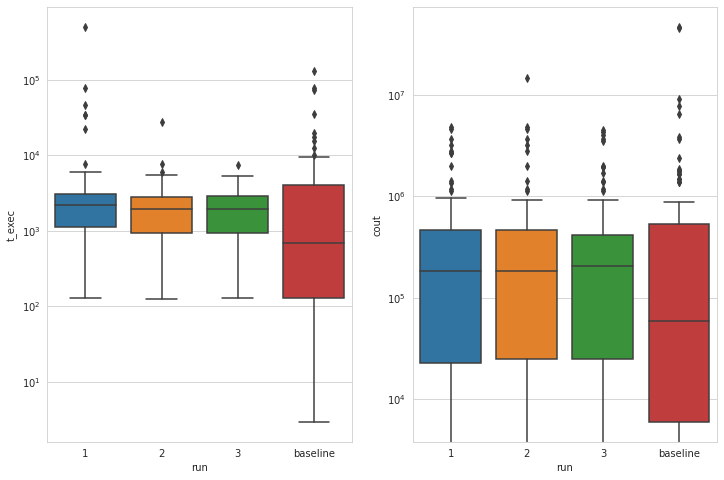

In [9]:
fig, (ax_t_exec, ax_cout) = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
g = sns.boxplot(data=df_bao, x="run", y="t_exec", ax=ax_t_exec)
g.set_yscale("log")
g = sns.boxplot(data=df_bao, x="run", y="cout", ax=ax_cout)
g.set_yscale("log")